<a href="https://colab.research.google.com/github/Mi-cha-ela/Retail_demand_analysis/blob/main/Woche_2_Feature_Engineering_User_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup &. Datenbasis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files

print("📁 Bitte lade zuerst session_base_clean.csv hoch")
uploaded = files.upload()

session_filename = list(uploaded.keys())[0]
df_sessions = pd.read_csv(session_filename)
print("session_base_clean.csv geladen ✔️")

print("📁 Bitte lade jetzt not_canceled_trips.csv hoch")
uploaded2 = files.upload()

trips_filename = list(uploaded2.keys())[0]
df_trips = pd.read_csv(trips_filename)
print("not_canceled_trips.csv geladen ✔️")


📁 Bitte lade zuerst session_base_clean.csv hoch


Saving session_base_clean.csv to session_base_clean.csv
session_base_clean.csv geladen ✔️
📁 Bitte lade jetzt not_canceled_trips.csv hoch


Saving not_canceled_trips.csv to not_canceled_trips.csv
not_canceled_trips.csv geladen ✔️


In [2]:
df_sessions.shape, df_trips.shape


((50000, 35), (15489, 42))

In [3]:
df_trips.columns

Index(['session_id', 'user_id', 'trip_id', 'session_start', 'session_end',
       'session_duration', 'page_clicks', 'flight_discount',
       'flight_discount_amount', 'hotel_discount', 'hotel_discount_amount',
       'flight_booked', 'hotel_booked', 'cancellation', 'birthdate', 'gender',
       'married', 'has_children', 'home_country', 'home_city', 'home_airport',
       'home_airport_lat', 'home_airport_lon', 'sign_up_date',
       'origin_airport', 'destination', 'destination_airport', 'seats',
       'return_flight_booked', 'departure_time', 'return_time', 'checked_bags',
       'trip_airline', 'destination_airport_lat', 'destination_airport_lon',
       'base_fare_usd', 'hotel_name', 'nights', 'rooms', 'check_in_time',
       'check_out_time', 'hotel_price_per_room_night_usd'],
      dtype='object')

In [4]:
list(df_trips.columns)


['session_id',
 'user_id',
 'trip_id',
 'session_start',
 'session_end',
 'session_duration',
 'page_clicks',
 'flight_discount',
 'flight_discount_amount',
 'hotel_discount',
 'hotel_discount_amount',
 'flight_booked',
 'hotel_booked',
 'cancellation',
 'birthdate',
 'gender',
 'married',
 'has_children',
 'home_country',
 'home_city',
 'home_airport',
 'home_airport_lat',
 'home_airport_lon',
 'sign_up_date',
 'origin_airport',
 'destination',
 'destination_airport',
 'seats',
 'return_flight_booked',
 'departure_time',
 'return_time',
 'checked_bags',
 'trip_airline',
 'destination_airport_lat',
 'destination_airport_lon',
 'base_fare_usd',
 'hotel_name',
 'nights',
 'rooms',
 'check_in_time',
 'check_out_time',
 'hotel_price_per_room_night_usd']

# Wie viele Tage vor der Reise buchen Nutzer?

**-> SPONTAN vs. PLANER**

In [5]:
# Zeitspalten in datetime konvertieren -nur mit echten Datumswerten kann ich Zeitabstände berechnen
df_trips["session_end"] = pd.to_datetime(df_trips["session_end"], errors="coerce")
df_trips["departure_time"] = pd.to_datetime(df_trips["departure_time"], errors="coerce")
df_trips["check_in_time"] = pd.to_datetime(df_trips["check_in_time"], errors="coerce")


In [6]:
# Tage vor Reise berechnen
# Idee:
# Wenn ein Flug gebucht wurde → Zeit bis Abflug
# Wenn kein Flug gebucht wurde → Zeit bis Hotel-Check-in

df_trips["days_before_trip"] = np.where(
    df_trips["flight_booked"],
    (df_trips["departure_time"] - df_trips["session_end"]).dt.days,
    (df_trips["check_in_time"] - df_trips["session_end"]).dt.days
)

df_trips = df_trips[df_trips["days_before_trip"] >= 0]

df_trips["days_before_trip"].describe()



,days_before_trip
count,13157.000000
mean,10.819108
std,31.005910
min,1.000000
25%,5.000000
50%,7.000000
75%,8.000000
max,365.000000


Hier wird der Buchunsvorlauf as Differenz zwischen Buchunszeitpunkt und tatsächlichem Reisebeginn gemessen.
- sind die Werte posetive?
- Gibt es realistische Min/Max-Werte?






In [7]:
# Zeitspalten sicher als datetime setzen - ohne das keine Zeitdifferenzen
df_trips["session_end"] = pd.to_datetime(df_trips["session_end"], errors="coerce")
df_trips["departure_time"] = pd.to_datetime(df_trips["departure_time"], errors="coerce")
df_trips["check_in_time"] = pd.to_datetime(df_trips["check_in_time"], errors="coerce")

# days_before_trip neu berechnen
import numpy as np

df_trips["days_before_trip"] = np.where(
    df_trips["flight_booked"],
    (df_trips["departure_time"] - df_trips["session_end"]).dt.days,
    (df_trips["check_in_time"] - df_trips["session_end"]).dt.days
)

df_trips = df_trips[df_trips["days_before_trip"] >= 0]

df_trips["booking_type"] = np.where(
    df_trips["days_before_trip"] <= 7,
    "spontan",
    "planer"
)

df_trips[["days_before_trip", "booking_type"]].head()


,days_before_trip,booking_type
0,6.0,spontan
2,8.0,planer
3,4.0,spontan
4,10.0,planer
5,56.0,planer


<Figure size 640x480 with 0 Axes>

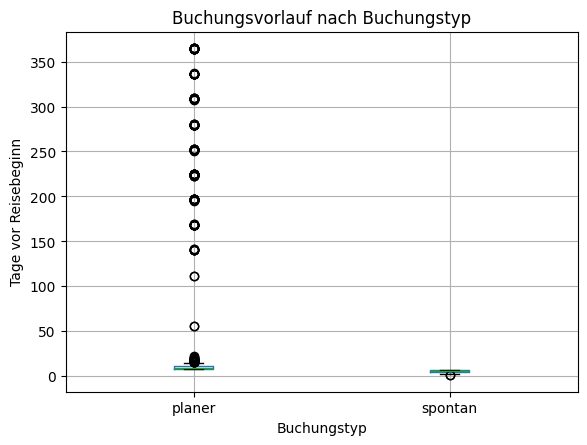

In [8]:
import matplotlib.pyplot as plt

plt.figure()
df_trips.boxplot(
    column="days_before_trip",
    by="booking_type"
)
plt.xlabel("Buchungstyp")
plt.ylabel("Tage vor Reisebeginn")
plt.title("Buchungsvorlauf nach Buchungstyp")
plt.suptitle("")
plt.show()


# Der Boxplot zeigt, dass der Median der Buchungsvorlaufzeit bei etwa 7 Tagen liegt.Die meisten Buchungen erfolgen innerhalb weniger Tage,*während einzelne frühe Buchungen als Ausreißer sichtbar sind.*

In [9]:
# Rabatt-Feature

df_trips["discount_trip"] = (
    df_trips["flight_discount"] | df_trips["hotel_discount"]
).astype(int)



# Finale Abgabe-Tabelle

df_final = df_trips[[
    "user_id",
    "trip_id",
    "days_before_trip",
    "booking_type",
    "discount_trip"
]]

df_final.head()


,user_id,trip_id,days_before_trip,booking_type,discount_trip
0,570279,570279-c48e05a90f9c44e8beb667ba9cc1f8a0,6.0,spontan,0
2,512201,512201-d198cb30dbe945a58808812558288792,8.0,planer,1
3,517491,517491-f17c9a923a054db2955c3f56a7d8486e,4.0,spontan,0
4,488865,488865-1154619ac9b34950b501ead668e4e825,10.0,planer,0
5,560978,560978-2d58a08a54cd4be1868835db447692f7,56.0,planer,0


In [34]:
df_final.to_csv("analysis_features.csv", index=False)


In [10]:
# User-Level AGGREGIEREN
user_trips = (
    df_trips
    .groupby("user_id")
    .agg(
        n_trips=("trip_id", "nunique"),
        avg_days_before_trip=("days_before_trip", "mean"),
        share_spontan=("booking_type", lambda x: (x == "spontan").mean()),
        share_discount=("discount_trip", "mean"),
        cancellation_rate=("cancellation", "mean"),
        avg_nights=("nights", "mean"),
        avg_rooms=("rooms", "mean")
    )
    .reset_index()
)

# ANNAHMEN(z.B.Businessreise)
df_trips["business_trip"] = (
    (df_trips["departure_time"].dt.weekday < 5) &
    (df_trips["rooms"] == 1) &
    (df_trips["checked_bags"] <= 1)
).astype(int)


df_trips["business_trip"] = (
    (df_trips["departure_time"].dt.weekday < 5) &
    (df_trips["rooms"] == 1) &
    (df_trips["checked_bags"] <= 1)
).astype(int)

# Da keine explizite Business-Kennzeichnung vorliegt, habe ich Businessreisen anhand typischer Merkmale approximiert

In [11]:
df_session = pd.read_csv("session_base_clean.csv")
df_session.head()
df_session.shape

user_sessions = (
    df_session
    .groupby("user_id")
    .agg(
        avg_session_duration=("session_duration", "mean"),
        avg_page_clicks=("page_clicks", "mean"),
        n_sessions=("session_id", "nunique")
    )
    .reset_index()
)

user_sessions.head()
df_session['session_duration'].describe()

,session_duration
count,50000.000000
mean,108.809280
std,82.449233
min,6.000000
25%,43.000000
50%,85.000000
75%,154.000000
max,320.500000


In [12]:

# User-Level Session Features (Median)


user_sessions = (
    df_session
    .groupby("user_id")
    .agg(
        median_session_duration=("session_duration", "median"),
        median_page_clicks=("page_clicks", "median"),
        n_sessions=("session_id", "nunique")
    )
    .reset_index()
)

user_sessions.head()



,user_id,median_session_duration,median_page_clicks,n_sessions
0,23557,69.5,9.0,8
1,79965,168.0,23.0,7
2,94883,31.0,4.0,7
3,101486,146.0,19.5,8
4,101961,133.0,18.0,8


Die Session-basierten Nutzermerkmale unterscheiden sich deutlich zwischen einzelnen Nutzern und zeigen verschiedene Interaktionsmuster, von kurzen, zielgerichteten Sessions bis hin zu längeren, klickintensiven Recherchephasen.

Kurzfassung für Folie:

Nutzer zeigen heterogenes, aber plausibles Sessionverhalten.

In [13]:
user_trips.head()



,user_id,n_trips,avg_days_before_trip,share_spontan,share_discount,cancellation_rate,avg_nights,avg_rooms
0,94883,2,6.500000,0.5,0.000000,0.0,0.5,1.5
1,101486,1,9.000000,0.0,0.000000,0.0,3.0,1.0
2,101961,5,5.600000,0.8,0.200000,0.0,3.8,1.0
3,118043,3,8.666667,0.0,0.333333,0.0,4.5,1.5
4,120851,1,7.000000,1.0,0.000000,0.0,11.0,1.0


In [14]:
# Zusammenführung (Merge)
# User_Level

user_base = (
    user_trips
    .merge(
        user_sessions,
        on="user_id",
        how="left"
    )
)

user_base.head()


,user_id,n_trips,avg_days_before_trip,share_spontan,share_discount,cancellation_rate,avg_nights,avg_rooms,median_session_duration,median_page_clicks,n_sessions
0,94883,2,6.500000,0.5,0.000000,0.0,0.5,1.5,31.0,4.0,7
1,101486,1,9.000000,0.0,0.000000,0.0,3.0,1.0,146.0,19.5,8
2,101961,5,5.600000,0.8,0.200000,0.0,3.8,1.0,133.0,18.0,8
3,118043,3,8.666667,0.0,0.333333,0.0,4.5,1.5,137.0,18.0,8
4,120851,1,7.000000,1.0,0.000000,0.0,11.0,1.0,44.5,6.0,8


Die nutzerbezogenen Reise-Features werden mit den aggregierten Session-Features auf User-Level zusammengeführt.
Dadurch entsteht eine konsolidierte Nutzerbasis, die sowohl Buchungs- als auch Interaktionsverhalten abbildet.


Reise- und Sessionverhalten werden auf Nutzerebene kombiniert.

In [15]:
user_base.shape
user_base.isna().mean().round(3)

user_base.to_csv("user_base.csv", index=False)


In [17]:
# Manuelle Nutzersegmente
user_base["segment_manual"] = "Sonstige"

user_base.loc[user_base["n_trips"] >= 5, "segment_manual"] = "Vielreisende"
user_base.loc[user_base["share_spontan"] >= 0.7, "segment_manual"] = "Spontanbucher"
user_base.loc[user_base["avg_days_before_trip"] >= 14, "segment_manual"] = "Planer"

user_base['segment_manual'].value_counts()

,count
segment_manual,
Sonstige,2496
Spontanbucher,2077
Vielreisende,249
Planer,223


Die Nutzer werden anhand einfacher Schwellenwerte in grobe Verhaltenssegmente eingeteilt.

In [22]:
# Business vs. Leisure (Annahme-basiert)
# Reisetyp approximieren (keine Wahrheit, sondern Heuristik)
# =========================
# Business-Reise-Heuristik
# =========================

user_base["business_likely"] = (
    (user_base["avg_nights"] <= 2) &
    (user_base["avg_rooms"] == 1) &
    (user_base["share_spontan"] >= 0.5)
).astype(int)

user_base["business_likely"].value_counts()

user_base[[
    "n_trips",
    "avg_nights",
    "avg_rooms",
    "share_spontan",
    "business_likely"
]].head(10)


,n_trips,avg_nights,avg_rooms,share_spontan,business_likely
0,2,0.500000,1.500000,0.500000,0
1,1,3.000000,1.000000,0.000000,0
2,5,3.800000,1.000000,0.800000,0
3,3,4.500000,1.500000,0.000000,0
4,1,11.000000,1.000000,1.000000,0
5,3,1.666667,1.333333,0.333333,0
6,1,NaN,NaN,1.000000,0
7,5,5.000000,1.200000,0.800000,0
8,1,2.000000,1.000000,0.000000,0
9,3,1.333333,1.000000,0.333333,0


# Businessreisen werden anhand typischer Merkmale approximiert, da keine explizite Kennzeichnung vorliegt.

In [19]:
# Daten modellfähig machen, nicht modelieren
# =========================
# Features für ML vorbereiten


features_for_ml = user_base[[
    "n_trips",
    "avg_days_before_trip",
    "share_spontan",
    "share_discount",
    "cancellation_rate",
    "avg_nights",
    "median_session_duration",
    "median_page_clicks",
    "n_sessions"
]]

features_for_ml.describe()


,n_trips,avg_days_before_trip,share_spontan,share_discount,cancellation_rate,avg_nights,median_session_duration,median_page_clicks,n_sessions
count,5045.000000,5045.000000,5045.000000,5045.000000,5045.0,4859.000000,5045.000000,5045.000000,5045.000000
mean,2.607929,12.437661,0.614017,0.254759,0.0,2.778969,97.976561,13.108424,7.359762
std,1.287289,31.049071,0.350907,0.311478,0.0,2.037116,39.962381,5.345300,1.016325
min,1.000000,2.000000,0.000000,0.000000,0.0,0.000000,16.000000,2.000000,2.000000
25%,2.000000,6.000000,0.400000,0.000000,0.0,1.500000,67.500000,9.000000,7.000000
50%,2.000000,7.000000,0.666667,0.166667,0.0,2.333333,93.000000,12.500000,7.000000
75%,3.000000,8.000000,1.000000,0.500000,0.0,3.500000,125.500000,17.000000,8.000000
max,8.000000,365.000000,1.000000,1.000000,0.0,25.000000,320.500000,43.500000,12.000000


# Die Feature-Tabelle dient als Grundlage für eine spätere Segmentierung mittels Clustering

In [20]:
user_base.to_csv("user_base.csv", index=False)


📌 **Ziel der Analyse**

Ziel der Analyse ist es, das Buchungs- und Nutzungsverhalten auf User-Level zu aggregieren und für eine Segmentierung vorzubereiten.

📌 **Zentrale Erkenntnisse**

Buchungsverhalten

Die Mehrheit der Nutzer bucht Reisen kurzfristig. Der Median des Buchungsvorlaufs liegt bei rund sieben Tagen, während einzelne sehr frühe Buchungen den Durchschnitt erhöhen.

Sessionverhalten

Nutzer unterscheiden sich deutlich in ihrem Interaktionsverhalten. Die Verwendung von Medianwerten führt zu stabilen, gut interpretierbaren Session-Features.

Rabattnutzung

Rabatte werden nur von einem Teil der Nutzer genutzt und stellen ein differenzierendes Merkmal im Buchungsverhalten dar.

📌 **Nutzersegmente**

Auf Basis zentraler Verhaltensmerkmale wurden Nutzer manuell in grobe Segmente wie Vielreisende, Spontanbucher und Planer eingeteilt.

📌 **Business vs. Leisure**

Da keine explizite Kennzeichnung für Geschäftsreisen vorliegt, wurde der Reisetyp heuristisch anhand typischer Buchungsmuster approximiert.

📌 **Ergebnis**

Die resultierende User-Level-Tabelle stellt eine konsolidierte und erklärbare Grundlage für weitere Segmentierungen oder modellbasierte Analysen dar.

# Warum bewusst kein ML gerechnet wurde



📌 **Sachliche Begründung**

Eine modellbasierte Segmentierung wurde bewusst nicht durchgeführt.
Der Fokus der Analyse liegt auf der sauberen Feature-Definition, Aggregation und inhaltlichen Interpretierbarkeit der Nutzermerkmale.

📌 **Fachlicher Hintergrund**

Für ein Clustering wären zusätzliche Schritte wie Feature-Skalierung, Auswahl der Clusteranzahl und Validierung der Ergebnisse erforderlich gewesen.
Diese Schritte liegen außerhalb des Analysefokus.

📌 **Positiver Ausblick**

Die vorbereitete Feature-Matrix ermöglicht eine spätere Erweiterung um Clustering- oder Klassifikationsmodelle.